# Embeddings

<img src="https://raw.githubusercontent.com/GokuMohandas/practicalAI/master/images/logo.png" width=150>

So far, we've represented text in a bagged one-hot encoded form which is a n-dimensional array where each index corresponds to a token. The value at that index corresponds to the number of times the word appears in the sentence. This method forces us to completely lose the structural information in our inputs. 

```python
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]```
 
 We've also represented our input in a one-hot encoded form where each token is represented by an n-dimensional array. T
 
 ```python
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
```

his allows us to preserve the structural information but there are two major disadvantages here. If we have a large vocabulary, the representation length for each token will be massive leading to large computes. And though we preserve the structure within the text, the actual representation for each token does not preserve any relationship with respect to other tokens.

In this notebook, we're going to learn about embeddings and how they address all the shortcomings of the representation methods we've seen so far.





# Overview

* **Objective:**  Represent tokens in text that capture the intrinsic semantic relationships.
* **Advantages:** 
    * Low-dimensionality while capturing relationships.
    * Interpretable token representations
* **Disadvantages:** None
* **Miscellaneous:** There are lot's of pretrained embeddings to choose from but you can also train your own from scratch.

# Learning embeddings

The main idea of embeddings is to have fixed length representations for the tokens in a text regardless of the number of tokens in the vocabulary. So instead of each token representation having the shape [1XV] where V is vocab size, each token now has the shape [1 X D] where D is the embedding size (usually 50, 100, 200, 300). The numbers in the representation will no longer be 0s and 1s but rather floats that represent that token in a D-dimensional latent space. If the embeddings really did capture the relationship between tokens, then we should be able to inspect this latent space and confirm known relationships (we'll do this soon).

But how do we learn the embeddings the first place? The intuition behind embeddings is that the definition of a token depends on the token itself but on it's context. There are several different ways of doing this:

1. Given the word in the context, predict the target word (CBOW - continuous bag of words).
2. Given the target word, predict the context word (skip-gram).
3. Given a sequence of words, predict the next word (LM - language modeling).

All of these approaches involve create data to train our model on. Every word in a sentence becomes the target word and the context words are determines by a window. In the image below (skip-gram), the window size is 2. We repeat this for every sentence in our corpus and this results in our training data for the unsupervised task. This in an unsupervised learning technique since we don't have official labels for contexts. The idea is that similar target words will appear with similar contexts and we can learn this relationship by repeatedly training our mode with (context, target) pairs.

<img src="https://raw.githubusercontent.com/GokuMohandas/practicalAI/master/images/skipgram.png" width=600>

We can learn embeddings using any of these approaches above and some work better than others. You can inspect the learned embeddings but the best way to choose an approach is to empirically validate the performance on a supervised task. We can learn embeddings by creating our models in PyTorch but instead, we're going to use a library that specializes in embeddings and topic modeling called [Gensim](https://radimrehurek.com/gensim/). 

In [0]:
!pip install gensim 

In [0]:
import os
from argparse import Namespace
import gensim
from gensim.models import Word2Vec
import json
import nltk; nltk.download('punkt')
import numpy as np
import pandas as pd
import re
import urllib
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [0]:
args = Namespace(
    seed=1234,
    data_file="harrypotter.txt",
    embedding_dim=100,
    window=5,
    min_count=3,
    skip_gram=1, # 0 = CBOW
    negative_sampling=20,
)

In [0]:
# Upload data from GitHub to notebook's local drive
url = "https://raw.githubusercontent.com/GokuMohandas/practicalAI/master/data/harrypotter.txt"
response = urllib.request.urlopen(url)
html = response.read()
with open(args.data_file, 'wb') as fp:
    fp.write(html)

In [0]:
# Split text into sentences
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
with open(args.data_file, encoding='cp1252') as fp:
    book = fp.read()
sentences = tokenizer.tokenize(book)
print (len(sentences))
print (sentences[11])

15640
Snape nodded, but did not elaborate.


In [0]:
# Preprocessing
def preprocess_text(text):
    text = ' '.join(word.lower() for word in text.split(" "))
    text = re.sub(r"([.,!?])", r" \1 ", text)
    text = re.sub(r"[^a-zA-Z.,!?]+", r" ", text)
    text = text.strip()
    return text

In [0]:
# Clean sentences
sentences = [preprocess_text(sentence) for sentence in sentences]
print (sentences[11])

snape nodded , but did not elaborate .


In [0]:
# Process sentences for gensim
sentences = [sentence.split(" ") for sentence in sentences]
print (sentences[11])

['snape', 'nodded', ',', 'but', 'did', 'not', 'elaborate', '.']


When we have large vocabularies to learn embeddings for, things can get complex very quickly. Recall that the backpropagation with softmax updates both the correct and incorrect class weights. This becomes a massive computation for every backwas pass we do so a workaround is to use [negative sampling](http://mccormickml.com/2017/01/11/word2vec-tutorial-part-2-negative-sampling/) which only updates the correct class and a few arbitrary incorrect classes (negative_sampling=20). We're able to do this because of the large amount of training data where we'll see the same word as the target class multiple times.



In [0]:
# Super fast because of optimized C code under the hood
model = Word2Vec(sentences=sentences, size=args.embedding_dim, 
                 window=args.window, min_count=args.min_count, 
                 sg=args.skip_gram, negative=args.negative_sampling)
print (model)

Word2Vec(vocab=4837, size=100, alpha=0.025)


In [0]:
# Vector for each word
model.wv.get_vector("potter")

array([ 0.32694522, -0.10700909, -0.00860276, -0.05530049,  0.24259742,
       -0.07497355,  0.42262644, -0.15363652, -0.30781576,  0.10575014,
        0.50577927, -0.1400549 ,  0.08517408, -0.1475271 ,  0.13185714,
       -0.22599436,  0.3054618 ,  0.354861  ,  0.32434312, -0.02844616,
        0.06013903,  0.01005598, -0.36263752, -0.02126057,  0.38369304,
        0.13219145, -0.54810864, -0.04936467, -0.26732844, -0.49601853,
       -0.07046658, -0.21352579,  0.06764964, -0.09502997, -0.07174117,
        0.24904843, -0.22878776, -0.00619049, -0.20751736, -0.16108654,
       -0.15955919, -0.12492364, -0.30763483,  0.19201335,  0.3745323 ,
        0.2801566 , -0.14452581,  0.05367172, -0.41522124,  0.15142794,
       -0.04702566, -0.39030793,  0.17267054,  0.05625816,  0.59319174,
        0.26723522,  0.2216919 ,  0.037455  ,  0.09900667, -0.42336655,
        0.23568399,  0.05742889,  0.15896225, -0.34813148,  0.09190734,
       -0.25708205,  0.25743866, -0.41044408,  0.03171714,  0.42

In [0]:
# Get nearest neighbors (excluding itself)
model.wv.most_similar(positive="scar", topn=5)

[('pain', 0.9464543461799622),
 ('forehead', 0.9311617612838745),
 ('prickling', 0.9278696179389954),
 ('burned', 0.9236202836036682),
 ('mouth', 0.9218926429748535)]

In [0]:
# Save the weights 
model.wv.save_word2vec_format('model.txt', binary=False)

# Pretrained embeddings

We can learn embeddings from scratch using one of the approaches above but we can also leverage pretrained embeddings that have been trained on millions of documents. Popular ones include Word2Vec (skip-gram) or GloVe (global word-word co-occurrence). We can validate that these embeddings captured meaningful semantic relationships by confirming them.

In [0]:
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models import KeyedVectors
from io import BytesIO
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from zipfile import ZipFile
from urllib.request import urlopen

In [0]:
# Unzip the file (may take ~3 minutes)
resp = urlopen('http://nlp.stanford.edu/data/glove.6B.zip')
zipfile = ZipFile(BytesIO(resp.read()))
zipfile.namelist()

['glove.6B.50d.txt',
 'glove.6B.100d.txt',
 'glove.6B.200d.txt',
 'glove.6B.300d.txt']

In [0]:
# Write embeddings
embeddings_file = 'glove.6B.{0}d.txt'.format(args.embedding_dim)
zipfile.extract(embeddings_file)

'/content/glove.6B.100d.txt'

In [0]:
# Save GloVe embeddings to local directory in word2vec format
word2vec_output_file = '{0}.word2vec'.format(embeddings_file)
glove2word2vec(embeddings_file, word2vec_output_file)

(400000, 100)

In [0]:
# Load embeddings (may take a minute)
glove = KeyedVectors.load_word2vec_format(word2vec_output_file, binary=False)

In [0]:
# (king - man) + woman = ?
glove.most_similar(positive=['woman', 'king'], negative=['man'], topn=5)

[('queen', 0.7698541283607483),
 ('monarch', 0.6843380928039551),
 ('throne', 0.6755735874176025),
 ('daughter', 0.6594556570053101),
 ('princess', 0.6520534753799438)]

In [0]:
# Get nearest neighbors (exlcusing itself)
glove.wv.most_similar(positive="goku", topn=5)

[('gohan', 0.7246542572975159),
 ('bulma', 0.6497020125389099),
 ('raistlin', 0.6443604230880737),
 ('skaar', 0.6316742897033691),
 ('guybrush', 0.6231324672698975)]

In [0]:
# Reduce dimensionality for plotting
X = glove[glove.wv.vocab]
pca = PCA(n_components=2)
pca_results = pca.fit_transform(X)

In [0]:
def plot_embeddings(words, embeddings, pca_results):
    for word in words:
        index = embeddings.index2word.index(word)
        plt.scatter(pca_results[index, 0], pca_results[index, 1])
        plt.annotate(word, xy=(pca_results[index, 0], pca_results[index, 1]))
    plt.show()

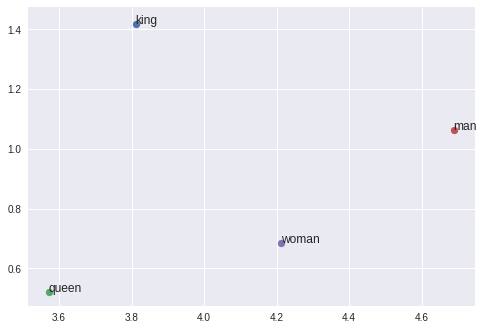

In [0]:
plot_embeddings(words=["king", "queen", "man", "woman"], embeddings=glove, 
                pca_results=pca_results)

In [0]:
# Bias in embeddings
glove.most_similar(positive=['woman', 'doctor'], negative=['man'], topn=5)

[('nurse', 0.7735227346420288),
 ('physician', 0.7189429998397827),
 ('doctors', 0.6824328303337097),
 ('patient', 0.6750682592391968),
 ('dentist', 0.6726033687591553)]

# Using Embeddings

There are several different ways to use embeddings. 

1. Use your own trained embeddings (trained on an unsupervised dataset).
2. Use pretrained embeddings (GloVe, word2vec, etc.)
3. Randomly initialized embeddings.

Once you have chosen embeddings, you can choose to freeze them or continue to train them using the supervised data (this could lead to overfitting). In this example, we're going to use GloVe embeddings and freeze them during training. Our task will be to predict an article's category given its title.

## Set up

In [0]:
# Loading PyTorch library
!pip3 install http://download.pytorch.org/whl/cpu/torch-0.4.1-cp36-cp36m-linux_x86_64.whl
!pip3 install torchvision

In [0]:
import os
from argparse import Namespace
import collections
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import torch

In [0]:
# Set Numpy and PyTorch seeds
def set_seeds(seed, cuda):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if cuda:
        torch.cuda.manual_seed_all(seed)
        
# Creating directories
def handle_dirs(dirpath):
    if not os.path.exists(dirpath):
        os.makedirs(dirpath)

In [0]:
# Arguments
args = Namespace(
    seed=1234,
    cuda=False,
    shuffle=True,
    data_file="news.csv",
    split_data_file="split_news.csv",
    vectorizer_file="vectorizer.json",
    model_state_file="model.pth",
    save_dir="news",
    reload_from_files=False,
    train_size=0.7,
    val_size=0.15,
    test_size=0.15,
    cutoff=25, # token must appear at least <cutoff> times to be in SequenceVocabulary
    num_epochs=5,
    early_stopping_criteria=5,
    learning_rate=1e-3,
    batch_size=64,
    num_filters=100,
    embedding_dim=100,
    hidden_dim=100,
    dropout_p=0.1,
)

# Set seeds
set_seeds(seed=args.seed, cuda=args.cuda)

# Create save dir
handle_dirs(args.save_dir)

# Expand filepaths
args.vectorizer_file = os.path.join(args.save_dir, args.vectorizer_file)
args.model_state_file = os.path.join(args.save_dir, args.model_state_file)
print("Expanded filepaths: ")
print("\t{}".format(args.vectorizer_file))
print("\t{}".format(args.model_state_file))

# Check CUDA
if not torch.cuda.is_available():
    args.cuda = False
args.device = torch.device("cuda" if args.cuda else "cpu")
print("Using CUDA: {}".format(args.cuda))

Expanded filepaths: 
	news/vectorizer.json
	news/model.pth
Using CUDA: False


## Data

In [0]:
import re
import urllib

In [0]:
# Upload data from GitHub to notebook's local drive
url = "https://raw.githubusercontent.com/GokuMohandas/practicalAI/master/data/news.csv"
response = urllib.request.urlopen(url)
html = response.read()
with open(args.data_file, 'wb') as fp:
    fp.write(html)

In [0]:
# Raw data
df = pd.read_csv(args.data_file, header=0)
df.head()

,category,title
0,Business,Wall St. Bears Claw Back Into the Black (Reuters)
1,Business,Carlyle Looks Toward Commercial Aerospace (Reu...
2,Business,Oil and Economy Cloud Stocks' Outlook (Reuters)
3,Business,Iraq Halts Oil Exports from Main Southern Pipe...
4,Business,"Oil prices soar to all-time record, posing new..."


In [0]:
# Split by category
by_category = collections.defaultdict(list)
for _, row in df.iterrows():
    by_category[row.category].append(row.to_dict())
for category in by_category:
    print ("{0}: {1}".format(category, len(by_category[category])))

Business: 30000
Sci/Tech: 30000
Sports: 30000
World: 30000


In [0]:
# Create split data
final_list = []
for _, item_list in sorted(by_category.items()):
    if args.shuffle:
        np.random.shuffle(item_list)
    n = len(item_list)
    n_train = int(args.train_size*n)
    n_val = int(args.val_size*n)
    n_test = int(args.test_size*n)

  # Give data point a split attribute
    for item in item_list[:n_train]:
        item['split'] = 'train'
    for item in item_list[n_train:n_train+n_val]:
        item['split'] = 'val'
    for item in item_list[n_train+n_val:]:
        item['split'] = 'test'  

    # Add to final list
    final_list.extend(item_list)

In [0]:
# df with split datasets
split_df = pd.DataFrame(final_list)
split_df["split"].value_counts()

train    84000
test     18000
val      18000
Name: split, dtype: int64

In [0]:
# Preprocessing
def preprocess_text(text):
    text = ' '.join(word.lower() for word in text.split(" "))
    text = re.sub(r"([.,!?])", r" \1 ", text)
    text = re.sub(r"[^a-zA-Z.,!?]+", r" ", text)
    return text
    
split_df.title = split_df.title.apply(preprocess_text)

In [0]:
# Save to CSV
split_df.to_csv(args.split_data_file, index=False)
split_df.head()

,category,split,title
0,Business,train,motorola third quarter earnings rise
1,Business,train,bye bye byrd
2,Business,train,"microsoft , palmone ink deal for mobile email ..."
3,Business,train,japan s topix index gains retailers led by dai...
4,Business,train,china to decide on curbs after aug data


## Vocabulary

In [0]:
class Vocabulary(object):
    def __init__(self, token_to_idx=None):

        # Token to index
        if token_to_idx is None:
            token_to_idx = {}
        self.token_to_idx = token_to_idx

        # Index to token
        self.idx_to_token = {idx: token \
                             for token, idx in self.token_to_idx.items()}

    def to_serializable(self):
        return {'token_to_idx': self.token_to_idx}

    @classmethod
    def from_serializable(cls, contents):
        return cls(**contents)

    def add_token(self, token):
        if token in self.token_to_idx:
            index = self.token_to_idx[token]
        else:
            index = len(self.token_to_idx)
            self.token_to_idx[token] = index
            self.idx_to_token[index] = token
        return index

    def add_tokens(self, tokens):
        return [self.add_token[token] for token in tokens]

    def lookup_token(self, token):
        return self.token_to_idx[token]

    def lookup_index(self, index):
        if index not in self.idx_to_token:
            raise KeyError("the index (%d) is not in the Vocabulary" % index)
        return self.idx_to_token[index]

    def __str__(self):
        return "<Vocabulary(size=%d)>" % len(self)

    def __len__(self):
        return len(self.token_to_idx)

In [0]:
# Vocabulary instance
category_vocab = Vocabulary()
for index, row in df.iterrows():
    category_vocab.add_token(row.category)
print (category_vocab) # __str__
print (len(category_vocab)) # __len__
print (category_vocab.lookup_token("Business"))
print (category_vocab.lookup_index(0))

<Vocabulary(size=4)>
4
0
Business


## Sequence vocabulary

Next, we're going to create our Vocabulary classes for the article's title, which is a sequence of tokens.

In [0]:
from collections import Counter
import string

In [0]:
class SequenceVocabulary(Vocabulary):
    def __init__(self, token_to_idx=None, unk_token="<UNK>",
                 mask_token="<MASK>", begin_seq_token="<BEGIN>",
                 end_seq_token="<END>"):

        super(SequenceVocabulary, self).__init__(token_to_idx)

        self.mask_token = mask_token
        self.unk_token = unk_token
        self.begin_seq_token = begin_seq_token
        self.end_seq_token = end_seq_token

        self.mask_index = self.add_token(self.mask_token)
        self.unk_index = self.add_token(self.unk_token)
        self.begin_seq_index = self.add_token(self.begin_seq_token)
        self.end_seq_index = self.add_token(self.end_seq_token)
        
        # Index to token
        self.idx_to_token = {idx: token \
                             for token, idx in self.token_to_idx.items()}

    def to_serializable(self):
        contents = super(SequenceVocabulary, self).to_serializable()
        contents.update({'unk_token': self.unk_token,
                         'mask_token': self.mask_token,
                         'begin_seq_token': self.begin_seq_token,
                         'end_seq_token': self.end_seq_token})
        return contents

    def lookup_token(self, token):
        return self.token_to_idx.get(token, self.unk_index)
    
    def lookup_index(self, index):
        if index not in self.idx_to_token:
            raise KeyError("the index (%d) is not in the SequenceVocabulary" % index)
        return self.idx_to_token[index]
    
    def __str__(self):
        return "<SequenceVocabulary(size=%d)>" % len(self.token_to_idx)

    def __len__(self):
        return len(self.token_to_idx)


In [0]:
# Get word counts
word_counts = Counter()
for title in split_df.title:
    for token in title.split(" "):
        if token not in string.punctuation:
            word_counts[token] += 1

# Create SequenceVocabulary instance
title_vocab = SequenceVocabulary()
for word, word_count in word_counts.items():
    if word_count >= args.cutoff:
        title_vocab.add_token(word)
print (title_vocab) # __str__
print (len(title_vocab)) # __len__
print (title_vocab.lookup_token("general"))
print (title_vocab.lookup_index(805))

<SequenceVocabulary(size=4400)>
4400
792
friends


## Vectorizer

In [0]:
class NewsVectorizer(object):
    def __init__(self, title_vocab, category_vocab):
        self.title_vocab = title_vocab
        self.category_vocab = category_vocab

    def vectorize(self, title, title_length=-1):
        indices = [self.title_vocab.lookup_token(token) for token in title.split(" ")]
        indices = [self.title_vocab.begin_seq_index] + indices + \
            [self.title_vocab.end_seq_index]
        
        if title_length < 0:
            title_length = len(indices)

        vector = np.zeros(title_length, dtype=np.int64)
        vector[:len(indices)] = indices
        vector[len(indices):] = self.title_vocab.mask_index

        return vector
    
    def unvectorize(self, vector):
        tokens = [self.title_vocab.lookup_index(index) for index in vector]
        title = " ".join(token for token in tokens)
        return title

    @classmethod
    def from_dataframe(cls, df, cutoff=25):
        
        # Create class vocab
        category_vocab = Vocabulary()        
        for category in sorted(set(df.category)):
            category_vocab.add_token(category)

        # Get word counts
        word_counts = Counter()
        for title in df.title:
            for token in title.split(" "):
                word_counts[token] += 1
        
        # Create title vocab
        title_vocab = SequenceVocabulary()
        for word, word_count in word_counts.items():
            if word_count >= cutoff:
                title_vocab.add_token(word)
        
        return cls(title_vocab, category_vocab)

    @classmethod
    def from_serializable(cls, contents):
        title_vocab = SequenceVocabulary.from_serializable(contents['title_vocab'])
        category_vocab = Vocabulary.from_serializable(contents['category_vocab'])
        return cls(title_vocab=title_vocab, category_vocab=category_vocab)
    
    def to_serializable(self):
        return {'title_vocab': self.title_vocab.to_serializable(),
                'category_vocab': self.category_vocab.to_serializable()}

In [0]:
# Vectorizer instance
vectorizer = NewsVectorizer.from_dataframe(split_df)
print (vectorizer.title_vocab)
print (vectorizer.category_vocab)
vectorized_title = vectorizer.vectorize(preprocess_text(
    "Roger Federer wins the Wimbledon tennis tournament."))
print (np.shape(vectorized_title))
print (vectorized_title)
print (vectorizer.unvectorize(vectorized_title))

<SequenceVocabulary(size=4405)>
<Vocabulary(size=4)>
(11,)
[   2    1 4158  718   48    1 3781 3969   26  120    3]
<BEGIN> <UNK> federer wins the <UNK> tennis tournament .  <END>


## Dataset

In [0]:
from torch.utils.data import Dataset, DataLoader

In [0]:
class NewsDataset(Dataset):
    def __init__(self, df, vectorizer):
        self.df = df
        self.vectorizer = vectorizer
        
        # Max title length
        get_length = lambda title: len(title.split(" "))
        self.max_seq_length = max(map(get_length, df.title)) + 2 # (<BEGIN> + <END>)

        # Data splits
        self.train_df = self.df[self.df.split=='train']
        self.train_size = len(self.train_df)
        self.val_df = self.df[self.df.split=='val']
        self.val_size = len(self.val_df)
        self.test_df = self.df[self.df.split=='test']
        self.test_size = len(self.test_df)
        self.lookup_dict = {'train': (self.train_df, self.train_size), 
                            'val': (self.val_df, self.val_size),
                            'test': (self.test_df, self.test_size)}
        self.set_split('train')

        # Class weights (for imbalances)
        class_counts = df.category.value_counts().to_dict()
        def sort_key(item):
            return self.vectorizer.category_vocab.lookup_token(item[0])
        sorted_counts = sorted(class_counts.items(), key=sort_key)
        frequencies = [count for _, count in sorted_counts]
        self.class_weights = 1.0 / torch.tensor(frequencies, dtype=torch.float32)

    @classmethod
    def load_dataset_and_make_vectorizer(cls, split_data_file):
        df = pd.read_csv(split_data_file, header=0)
        train_df = df[df.split=='train']
        return cls(df, NewsVectorizer.from_dataframe(train_df))

    @classmethod
    def load_dataset_and_load_vectorizer(cls, split_data_file, vectorizer_filepath):
        df = pd.read_csv(split_data_file, header=0)
        vectorizer = cls.load_vectorizer_only(vectorizer_filepath)
        return cls(df, vectorizer)

    def load_vectorizer_only(vectorizer_filepath):
        with open(vectorizer_filepath) as fp:
            return NewsVectorizer.from_serializable(json.load(fp))

    def save_vectorizer(self, vectorizer_filepath):
        with open(vectorizer_filepath, "w") as fp:
            json.dump(self.vectorizer.to_serializable(), fp)

    def set_split(self, split="train"):
        self.target_split = split
        self.target_df, self.target_size = self.lookup_dict[split]

    def __str__(self):
        return "<Dataset(split={0}, size={1})".format(
            self.target_split, self.target_size)

    def __len__(self):
        return self.target_size

    def __getitem__(self, index):
        row = self.target_df.iloc[index]
        title_vector = self.vectorizer.vectorize(row.title, 
                                                 title_length=self.max_seq_length)
        category_index = self.vectorizer.category_vocab.lookup_token(row.category)
        return {'title': title_vector, 'category': category_index}

    def get_num_batches(self, batch_size):
        return len(self) // batch_size

    def generate_batches(self, batch_size, shuffle=True, drop_last=True, device="cpu"):
        dataloader = DataLoader(dataset=self, batch_size=batch_size, 
                                shuffle=shuffle, drop_last=drop_last)
        for data_dict in dataloader:
            out_data_dict = {}
            for name, tensor in data_dict.items():
                out_data_dict[name] = data_dict[name].to(device)
            yield out_data_dict

In [0]:
# Dataset instance
dataset = NewsDataset.load_dataset_and_make_vectorizer(args.split_data_file)
print (dataset) # __str__
title_vector = dataset[5]['title'] # __getitem__
print (title_vector)
print (dataset.vectorizer.unvectorize(title_vector))
print (dataset.class_weights)

<Dataset(split=train, size=84000)
[ 2 35 36 37 38 39  1  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0]
<BEGIN> greenspan predicts years of oil <UNK> <END> <MASK> <MASK> <MASK> <MASK> <MASK> <MASK> <MASK> <MASK> <MASK> <MASK> <MASK> <MASK> <MASK> <MASK> <MASK> <MASK> <MASK> <MASK> <MASK> <MASK> <MASK>
tensor([0.0000, 0.0000, 0.0000, 0.0000])


## Model

input → embedding → conv → FC 

We will be using 1d conv operations ([nn.Conv1D](https://pytorch.org/docs/stable/nn.html#torch.nn.Conv1d)) even though our inputs are words because we are not representing them at a character level. The inputs are of shape $\in \mathbb{R}^{NXSXE}$
* where:
    * N = batchsize
    * S = max sentence length 
    * E = embedding dim at a word level

In [0]:
import torch.nn as nn
import torch.nn.functional as F

In [0]:
class NewsModel(nn.Module):
    def __init__(self, embedding_dim, num_embeddings, num_input_channels, 
                 num_channels, hidden_dim, num_classes, dropout_p, 
                 pretrained_embeddings=None, freeze_embeddings=False,
                 padding_idx=0):
        super(NewsModel, self).__init__()
        
        if pretrained_embeddings is None:
            self.embeddings = nn.Embedding(embedding_dim=embedding_dim,
                                          num_embeddings=num_embeddings,
                                          padding_idx=padding_idx)
        else:
            pretrained_embeddings = torch.from_numpy(pretrained_embeddings).float()
            self.embeddings = nn.Embedding(embedding_dim=embedding_dim,
                                           num_embeddings=num_embeddings,
                                           padding_idx=padding_idx,
                                           _weight=pretrained_embeddings)
        
        # Conv weights
        self.conv = nn.ModuleList([nn.Conv1d(num_input_channels, num_channels, 
                                             kernel_size=f) for f in [2,3,4]])
     
        # FC weights
        self.dropout = nn.Dropout(dropout_p)
        self.fc1 = nn.Linear(num_channels*3, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, num_classes)
        
        if freeze_embeddings:
            self.embeddings.weight.requires_grad = False

    def forward(self, x_in, channel_first=False, apply_softmax=False):
        
        # Embed
        x_in = self.embeddings(x_in)

        # Rearrange input so num_channels is in dim 1 (N, C, L)
        if not channel_first:
            x_in = x_in.transpose(1, 2)
            
        # Conv outputs
        z1 = self.conv[0](x_in)
        z1 = F.max_pool1d(z1, z1.size(2)).squeeze(2)
        z2 = self.conv[1](x_in)
        z2 = F.max_pool1d(z2, z2.size(2)).squeeze(2)
        z3 = self.conv[2](x_in)
        z3 = F.max_pool1d(z3, z3.size(2)).squeeze(2)
        
        # Concat conv outputs
        z = torch.cat([z1, z2, z3], 1)

        # FC layers
        z = self.dropout(z)
        z = self.fc1(z)
        y_pred = self.fc2(z)
        
        if apply_softmax:
            y_pred = F.softmax(y_pred, dim=1)
        return y_pred

## Training

In [0]:
import torch.optim as optim

In [0]:
class Trainer(object):
    def __init__(self, dataset, model, model_state_file, save_dir, device, shuffle, 
               num_epochs, batch_size, learning_rate, early_stopping_criteria):
        self.dataset = dataset
        self.class_weights = dataset.class_weights.to(device)
        self.model = model.to(device)
        self.save_dir = save_dir
        self.device = device
        self.shuffle = shuffle
        self.num_epochs = num_epochs
        self.batch_size = batch_size
        self.loss_func = nn.CrossEntropyLoss(self.class_weights)
        self.optimizer = optim.Adam(self.model.parameters(), lr=learning_rate)
        self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            optimizer=self.optimizer, mode='min', factor=0.5, patience=1)
        self.train_state = {
            'stop_early': False, 
            'early_stopping_step': 0,
            'early_stopping_best_val': 1e8,
            'early_stopping_criteria': early_stopping_criteria,
            'learning_rate': learning_rate,
            'epoch_index': 0,
            'train_loss': [],
            'train_acc': [],
            'val_loss': [],
            'val_acc': [],
            'test_loss': -1,
            'test_acc': -1,
            'model_filename': model_state_file}
    
    def update_train_state(self):

        # Verbose
        print ("[EPOCH]: {0} | [LR]: {1} | [TRAIN LOSS]: {2:.2f} | [TRAIN ACC]: {3:.1f}% | [VAL LOSS]: {4:.2f} | [VAL ACC]: {5:.1f}%".format(
          self.train_state['epoch_index'], self.train_state['learning_rate'], 
            self.train_state['train_loss'][-1], self.train_state['train_acc'][-1], 
            self.train_state['val_loss'][-1], self.train_state['val_acc'][-1]))

        # Save one model at least
        if self.train_state['epoch_index'] == 0:
            torch.save(self.model.state_dict(), self.train_state['model_filename'])
            self.train_state['stop_early'] = False

        # Save model if performance improved
        elif self.train_state['epoch_index'] >= 1:
            loss_tm1, loss_t = self.train_state['val_loss'][-2:]

            # If loss worsened
            if loss_t >= self.train_state['early_stopping_best_val']:
                # Update step
                self.train_state['early_stopping_step'] += 1

            # Loss decreased
            else:
                # Save the best model
                if loss_t < self.train_state['early_stopping_best_val']:
                    torch.save(self.model.state_dict(), self.train_state['model_filename'])

                # Reset early stopping step
                self.train_state['early_stopping_step'] = 0

            # Stop early ?
            self.train_state['stop_early'] = self.train_state['early_stopping_step'] \
              >= self.train_state['early_stopping_criteria']
        return self.train_state
  
    def compute_accuracy(self, y_pred, y_target):
        _, y_pred_indices = y_pred.max(dim=1)
        n_correct = torch.eq(y_pred_indices, y_target).sum().item()
        return n_correct / len(y_pred_indices) * 100
  
    def run_train_loop(self):
        for epoch_index in range(self.num_epochs):
            self.train_state['epoch_index'] = epoch_index
      
            # Iterate over train dataset

            # setup: batch generator, set loss and acc to 0, set train mode on
            self.dataset.set_split('train')
            batch_generator = self.dataset.generate_batches(
                batch_size=self.batch_size, shuffle=self.shuffle, 
                device=self.device)
            running_loss = 0.0
            running_acc = 0.0
            self.model.train()

            for batch_index, batch_dict in enumerate(batch_generator):
                # the training routine is these 5 steps:

                # --------------------------------------
                # step 1. zero the gradients
                self.optimizer.zero_grad()

                # step 2. compute the output
                y_pred = self.model(batch_dict['title'])

                # step 3. compute the loss
                loss = self.loss_func(y_pred, batch_dict['category'])
                loss_t = loss.item()
                running_loss += (loss_t - running_loss) / (batch_index + 1)

                # step 4. use loss to produce gradients
                loss.backward()

                # step 5. use optimizer to take gradient step
                self.optimizer.step()
                # -----------------------------------------
                # compute the accuracy
                acc_t = self.compute_accuracy(y_pred, batch_dict['category'])
                running_acc += (acc_t - running_acc) / (batch_index + 1)

            self.train_state['train_loss'].append(running_loss)
            self.train_state['train_acc'].append(running_acc)

            # Iterate over val dataset

            # setup: batch generator, set loss and acc to 0; set eval mode on
            self.dataset.set_split('val')
            batch_generator = self.dataset.generate_batches(
                batch_size=self.batch_size, shuffle=self.shuffle, device=self.device)
            running_loss = 0.
            running_acc = 0.
            self.model.eval()

            for batch_index, batch_dict in enumerate(batch_generator):

                # compute the output
                y_pred =  self.model(batch_dict['title'])

                # step 3. compute the loss
                loss = self.loss_func(y_pred, batch_dict['category'])
                loss_t = loss.to("cpu").item()
                running_loss += (loss_t - running_loss) / (batch_index + 1)

                # compute the accuracy
                acc_t = self.compute_accuracy(y_pred, batch_dict['category'])
                running_acc += (acc_t - running_acc) / (batch_index + 1)

            self.train_state['val_loss'].append(running_loss)
            self.train_state['val_acc'].append(running_acc)

            self.train_state = self.update_train_state()
            self.scheduler.step(self.train_state['val_loss'][-1])
            if self.train_state['stop_early']:
                break
          
    def run_test_loop(self):
        self.dataset.set_split('test')
        batch_generator = self.dataset.generate_batches(
            batch_size=self.batch_size, shuffle=self.shuffle, device=self.device)
        running_loss = 0.0
        running_acc = 0.0
        self.model.eval()

        for batch_index, batch_dict in enumerate(batch_generator):
            # compute the output
            y_pred =  self.model(batch_dict['title'])

            # compute the loss
            loss = self.loss_func(y_pred, batch_dict['category'])
            loss_t = loss.item()
            running_loss += (loss_t - running_loss) / (batch_index + 1)

            # compute the accuracy
            acc_t = self.compute_accuracy(y_pred, batch_dict['category'])
            running_acc += (acc_t - running_acc) / (batch_index + 1)

        self.train_state['test_loss'] = running_loss
        self.train_state['test_acc'] = running_acc
    
    def plot_performance(self):
        # Figure size
        plt.figure(figsize=(15,5))

        # Plot Loss
        plt.subplot(1, 2, 1)
        plt.title("Loss")
        plt.plot(trainer.train_state["train_loss"], label="train")
        plt.plot(trainer.train_state["val_loss"], label="val")
        plt.legend(loc='upper right')

        # Plot Accuracy
        plt.subplot(1, 2, 2)
        plt.title("Accuracy")
        plt.plot(trainer.train_state["train_acc"], label="train")
        plt.plot(trainer.train_state["val_acc"], label="val")
        plt.legend(loc='lower right')

        # Save figure
        plt.savefig(os.path.join(self.save_dir, "performance.png"))

        # Show plots
        plt.show()
    
    def save_train_state(self):
        with open(os.path.join(self.save_dir, "train_state.json"), "w") as fp:
            json.dump(self.train_state, fp)

In [0]:
# Initialization
if args.reload_from_files:
    print ("Reloading!")
    dataset = NewsDataset.load_dataset_and_load_vectorizer(
        args.split_data_file,args.vectorizer_file)
else:
    print ("Creating from scratch!")
    dataset = NewsDataset.load_dataset_and_make_vectorizer(args.split_data_file)
    dataset.save_vectorizer(args.vectorizer_file)
vectorizer = dataset.vectorizer
model = NewsModel(embedding_dim=args.embedding_dim, 
                  num_embeddings=len(vectorizer.title_vocab), 
                  num_input_channels=args.embedding_dim, 
                  num_channels=args.num_filters, hidden_dim=args.hidden_dim, 
                  num_classes=len(vectorizer.category_vocab), 
                  dropout_p=args.dropout_p, pretrained_embeddings=None, 
                  padding_idx=vectorizer.title_vocab.mask_index)
print (model.named_modules)

Creating from scratch!
<bound method Module.named_modules of NewsModel(
  (embeddings): Embedding(3396, 100, padding_idx=0)
  (conv): ModuleList(
    (0): Conv1d(100, 100, kernel_size=(2,), stride=(1,))
    (1): Conv1d(100, 100, kernel_size=(3,), stride=(1,))
    (2): Conv1d(100, 100, kernel_size=(4,), stride=(1,))
  )
  (dropout): Dropout(p=0.1)
  (fc1): Linear(in_features=300, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=4, bias=True)
)>


In [0]:
# Train
trainer = Trainer(dataset=dataset, model=model, 
                  model_state_file=args.model_state_file, 
                  save_dir=args.save_dir, device=args.device,
                  shuffle=args.shuffle, num_epochs=args.num_epochs, 
                  batch_size=args.batch_size, learning_rate=args.learning_rate, 
                  early_stopping_criteria=args.early_stopping_criteria)
trainer.run_train_loop()

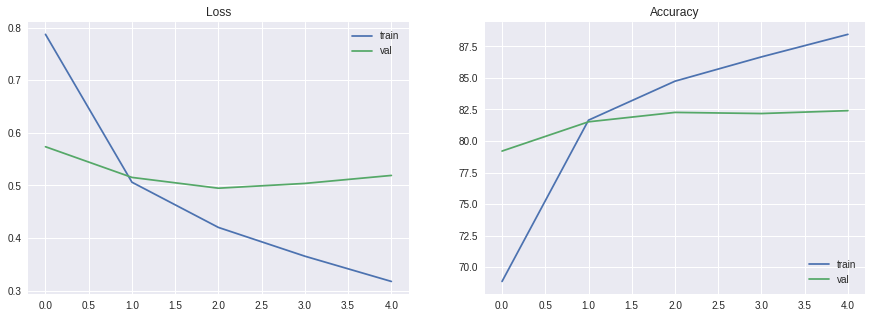

In [0]:
# Plot performance
trainer.plot_performance()

In [0]:
# Test performance
trainer.run_test_loop()
print("Test loss: {0:.2f}".format(trainer.train_state['test_loss']))
print("Test Accuracy: {0:.1f}%".format(trainer.train_state['test_acc']))

Test loss: 0.52
Test Accuracy: 81.9%


In [0]:
# Save all results
trainer.save_train_state()

## Using GloVe embeddings

We just used some randomly initialized embeddings and we were able to receive decent performance. Keep in mind that this may not always be the case and we may overfit on other datasets with this approach. We're now going to use pretrained GloVe embeddings to initialize our embeddings. We will train our model on the supervised task and assess the performance by first freezing these embeddings (so they don't change during training) and then not freezing them and allowing them to be trained. 

```python
pretrained_embeddings = torch.from_numpy(pretrained_embeddings).float()
self.embeddings = nn.Embedding(embedding_dim=embedding_dim, 
                               num_embeddings=num_embeddings, 
                               padding_idx=padding_idx, 
                               _weight=pretrained_embeddings)
```

In [0]:
def load_glove_embeddings(embeddings_file):
    word_to_idx = {}
    embeddings = []

    with open(embeddings_file, "r") as fp:
        for index, line in enumerate(fp):
            line = line.split(" ")
            word = line[0]
            word_to_idx[word] = index
            embedding_i = np.array([float(val) for val in line[1:]])
            embeddings.append(embedding_i)

    return word_to_idx, np.stack(embeddings)

def make_embeddings_matrix(words):
    word_to_idx, glove_embeddings = load_glove_embeddings(embeddings_file)
    embedding_dim = glove_embeddings.shape[1]
    embeddings = np.zeros((len(words), embedding_dim))
    for i, word in enumerate(words):
        if word in word_to_idx:
            embeddings[i, :] = glove_embeddings[word_to_idx[word]]
        else:
            embedding_i = torch.zeros(1, embedding_dim)
            nn.init.xavier_uniform_(embedding_i)
            embeddings[i, :] = embedding_i

    return embeddings

In [0]:
args.use_glove_embeddings = True

In [0]:
# Initialization
if args.reload_from_files:
    print ("Reloading!")
    dataset = NewsDataset.load_dataset_and_load_vectorizer(
        args.split_data_file,args.vectorizer_file)
else:
    print ("Creating from scratch!")
    dataset = NewsDataset.load_dataset_and_make_vectorizer(args.split_data_file)
    dataset.save_vectorizer(args.vectorizer_file)
vectorizer = dataset.vectorizer

# Create embeddings
embeddings = None
if args.use_glove_embeddings:
    embeddings_file = 'glove.6B.{0}d.txt'.format(args.embedding_dim)
    words = vectorizer.title_vocab.token_to_idx.keys()
    embeddings = make_embeddings_matrix(words=words)
    print ("<Embeddings(words={0}, dim={1})>".format(
        np.shape(embeddings)[0], np.shape(embeddings)[1]))

Creating from scratch!
<Embeddings(words=3396, dim=100)>
<bound method Module.named_modules of NewsModel(
  (embeddings): Embedding(3396, 100, padding_idx=0)
  (conv): ModuleList(
    (0): Conv1d(100, 100, kernel_size=(2,), stride=(1,))
    (1): Conv1d(100, 100, kernel_size=(3,), stride=(1,))
    (2): Conv1d(100, 100, kernel_size=(4,), stride=(1,))
  )
  (dropout): Dropout(p=0.1)
  (fc1): Linear(in_features=300, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=4, bias=True)
)>


In [0]:
# Initialize model
model = NewsModel(embedding_dim=args.embedding_dim, 
                  num_embeddings=len(vectorizer.title_vocab), 
                  num_input_channels=args.embedding_dim, 
                  num_channels=args.num_filters, hidden_dim=args.hidden_dim, 
                  num_classes=len(vectorizer.category_vocab), 
                  dropout_p=args.dropout_p, pretrained_embeddings=embeddings, 
                  padding_idx=vectorizer.title_vocab.mask_index)
print (model.named_modules)

In [0]:
# Train
trainer = Trainer(dataset=dataset, model=model, 
                  model_state_file=args.model_state_file, 
                  save_dir=args.save_dir, device=args.device,
                  shuffle=args.shuffle, num_epochs=args.num_epochs, 
                  batch_size=args.batch_size, learning_rate=args.learning_rate, 
                  early_stopping_criteria=args.early_stopping_criteria)
trainer.run_train_loop()

[EPOCH]: 0 | [LR]: 0.001 | [TRAIN LOSS]: 0.50 | [TRAIN ACC]: 81.9% | [VAL LOSS]: 0.45 | [VAL ACC]: 83.6%
[EPOCH]: 1 | [LR]: 0.001 | [TRAIN LOSS]: 0.41 | [TRAIN ACC]: 85.3% | [VAL LOSS]: 0.43 | [VAL ACC]: 84.5%
[EPOCH]: 2 | [LR]: 0.001 | [TRAIN LOSS]: 0.37 | [TRAIN ACC]: 86.8% | [VAL LOSS]: 0.43 | [VAL ACC]: 84.7%
[EPOCH]: 3 | [LR]: 0.001 | [TRAIN LOSS]: 0.33 | [TRAIN ACC]: 88.0% | [VAL LOSS]: 0.44 | [VAL ACC]: 84.2%
[EPOCH]: 4 | [LR]: 0.001 | [TRAIN LOSS]: 0.26 | [TRAIN ACC]: 90.6% | [VAL LOSS]: 0.49 | [VAL ACC]: 83.9%


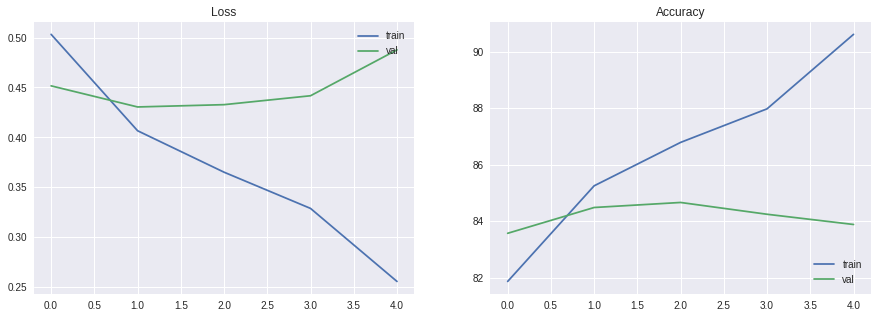

In [0]:
# Plot performance
trainer.plot_performance()

In [0]:
# Test performance
trainer.run_test_loop()
print("Test loss: {0:.2f}".format(trainer.train_state['test_loss']))
print("Test Accuracy: {0:.1f}%".format(trainer.train_state['test_acc']))

Test loss: 0.50
Test Accuracy: 83.3%


In [0]:
# Save all results
trainer.save_train_state()

## Freeze embeddings

Now we're going to freeze our GloVe embeddings and train on the supervised task. The only modification in the model is to turn on `freeze_embeddings`:

```python
if freeze_embeddings:
    self.embeddings.weight.requires_grad = False
```

In [0]:
args.freeze_embeddings = True

In [0]:
# Initialize model
model = NewsModel(embedding_dim=args.embedding_dim, 
                  num_embeddings=len(vectorizer.title_vocab), 
                  num_input_channels=args.embedding_dim, 
                  num_channels=args.num_filters, hidden_dim=args.hidden_dim, 
                  num_classes=len(vectorizer.category_vocab), 
                  dropout_p=args.dropout_p, pretrained_embeddings=embeddings,
                  freeze_embeddings=args.freeze_embeddings,
                  padding_idx=vectorizer.title_vocab.mask_index)
print (model.named_modules)

<bound method Module.named_modules of NewsModel(
  (embeddings): Embedding(3396, 100, padding_idx=0)
  (conv): ModuleList(
    (0): Conv1d(100, 100, kernel_size=(2,), stride=(1,))
    (1): Conv1d(100, 100, kernel_size=(3,), stride=(1,))
    (2): Conv1d(100, 100, kernel_size=(4,), stride=(1,))
  )
  (dropout): Dropout(p=0.1)
  (fc1): Linear(in_features=300, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=4, bias=True)
)>


In [0]:
# Train
trainer = Trainer(dataset=dataset, model=model, 
                  model_state_file=args.model_state_file, 
                  save_dir=args.save_dir, device=args.device,
                  shuffle=args.shuffle, num_epochs=args.num_epochs, 
                  batch_size=args.batch_size, learning_rate=args.learning_rate, 
                  early_stopping_criteria=args.early_stopping_criteria)
trainer.run_train_loop()

[EPOCH]: 0 | [LR]: 0.001 | [TRAIN LOSS]: 0.53 | [TRAIN ACC]: 80.8% | [VAL LOSS]: 0.48 | [VAL ACC]: 82.5%
[EPOCH]: 1 | [LR]: 0.001 | [TRAIN LOSS]: 0.45 | [TRAIN ACC]: 83.6% | [VAL LOSS]: 0.47 | [VAL ACC]: 83.2%
[EPOCH]: 2 | [LR]: 0.001 | [TRAIN LOSS]: 0.41 | [TRAIN ACC]: 85.0% | [VAL LOSS]: 0.46 | [VAL ACC]: 83.2%
[EPOCH]: 3 | [LR]: 0.001 | [TRAIN LOSS]: 0.39 | [TRAIN ACC]: 85.9% | [VAL LOSS]: 0.46 | [VAL ACC]: 83.4%
[EPOCH]: 4 | [LR]: 0.001 | [TRAIN LOSS]: 0.36 | [TRAIN ACC]: 86.8% | [VAL LOSS]: 0.45 | [VAL ACC]: 83.9%


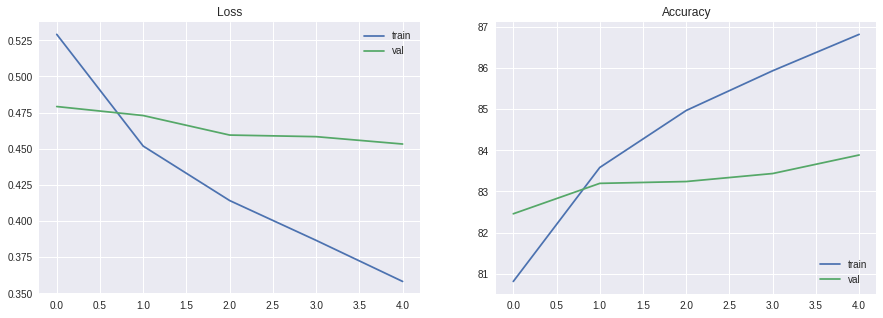

In [0]:
# Plot performance
trainer.plot_performance()

In [0]:
# Test performance
trainer.run_test_loop()
print("Test loss: {0:.2f}".format(trainer.train_state['test_loss']))
print("Test Accuracy: {0:.1f}%".format(trainer.train_state['test_acc']))

Test loss: 0.47
Test Accuracy: 83.2%


In [0]:
# Save all results
trainer.save_train_state()

So you can see that using GloVe embeddings but not freezing them resulted in the best results on the test dataset. Different tasks will yield different results so you need to choose whether or not to freeze your embeddings based on empirical results.

# TODO

* when to use skip-gram/CBOW
    * According to Mikolov:
        
        Skip-gram: works well with small amount of the training data, represents well even rare words or phrases.
        
        CBOW: several times faster to train than the skip-gram, slightly better accuracy for the frequent words
* Loading word2vec
* interpretable conv filters since we apply it on words here
* [contextualized word embeddings](https://arxiv.org/abs/1607.00578)